In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Read csv data
train = pd.read_csv("dataset_layer12/train.csv")
valid = pd.read_csv("dataset_layer12/valid.csv")

In [3]:
print("Shape of the train dataset : ", train.shape)
print("Shape of the valid dataset : ", valid.shape)

Shape of the train dataset :  (28520, 772)
Shape of the valid dataset :  (750, 772)


In [4]:
# Find out the number of rows with missing values for each column.
def check_missing_values(label):
    print("Missing values in {label}: {val}".format(label=label, val=train[label].isna().sum()))

# Check missing values in labels
for label in ['label_1', 'label_2', 'label_3', 'label_4']:
    check_missing_values(label)
    
# Check for missing values in feature columns
for i in range(1, 773-4):
    if train[label].isna().sum() > 0:
        check_missing_values('feature_' + str(i))
else:
    print("No missing values in feature columns.") 

Missing values in label_1: 0
Missing values in label_2: 480
Missing values in label_3: 0
Missing values in label_4: 0
No missing values in feature columns.


In [5]:
# Handling missing values in Label 2
train['label_2'].fillna(train['label_2'].mean().round(), inplace=True)
valid['label_2'].fillna(valid['label_2'].mean().round(), inplace=True)

train = train.astype({'label_2':'int'})
valid = valid.astype({'label_2':'int'})

# Confirm that the values have been filled
train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_1,label_2,label_3,label_4
0,0.031138,0.079892,0.157382,-0.014636,-0.051778,-0.021332,-0.073593,-0.005386,-0.212557,0.099683,...,-0.085248,-0.096007,-0.000766,0.021399,-0.041432,0.094806,45,28,1,6
1,0.113040,0.175731,0.217741,-0.196254,-0.010129,-0.030586,0.067114,-0.072412,-0.239192,0.104741,...,-0.090283,-0.053885,-0.010967,0.062209,-0.122958,0.192949,45,28,1,6
2,0.048570,0.091281,0.160776,-0.150937,0.020115,0.044117,-0.050092,-0.045661,-0.155332,0.117206,...,-0.021524,-0.008411,-0.006248,0.031468,-0.056915,0.154731,45,28,1,6
3,0.039212,0.118388,0.173831,-0.096659,-0.008702,0.061298,0.008974,-0.003277,-0.065046,0.095480,...,-0.071936,-0.023120,-0.007812,0.057600,-0.121892,0.072796,45,28,1,6
4,0.056019,0.170639,0.157917,-0.228605,-0.065965,-0.088732,-0.082243,-0.080568,-0.341500,0.142430,...,-0.155621,-0.079447,0.015316,0.127726,-0.151966,0.169634,45,28,1,6


In [6]:
# Separate features and target labels
X_train = train.iloc[:, :768]
y_train = train[['label_1', 'label_2', 'label_3', 'label_4']]

X_valid = valid.iloc[:, :768]
y_valid = valid[['label_1', 'label_2', 'label_3', 'label_4']]

# Check the dimensions to confirm
print(X_train.shape, X_valid.shape)
print(y_train.shape, y_valid.shape)

(28520, 768) (750, 768)
(28520, 4) (750, 4)


In [7]:
x_feature_names = ["feature_" + str(i) for i in range(1, 769)]
rob_scaler = RobustScaler()
rob_scaler.fit(X_train)


X_train_scaled = pd.DataFrame(rob_scaler.transform(X_train), columns=x_feature_names)
X_valid_scaled = pd.DataFrame(rob_scaler.transform(X_valid), columns=x_feature_names)

## Common functions

In [8]:
# Remove feature columns with high correlations

def reduce_correlations(corr_matrix, dataset, threshold):    
    removed = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            col = corr_matrix.columns[i]
            if abs(corr_matrix.iloc[i, j]) > threshold:
                removed.append(col)
            
    data_filtered = dataset.drop(columns=removed)
    return data_filtered

In [9]:
# calculate the accuracy of the model

# def evaluate_model(model, x, y):
#     y_pred = model.predict(x)
#     acc = accuracy_score(y, y_pred)
#     return acc

def evaluate_model(model, x, y):
    y_pred = model.predict(x)
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy: ", accuracy)
    cm = confusion_matrix(y, y_pred)
    print("Confusion matrix: ")
    print(cm)
    print("Precision, recall, f1-score: ")
    scores = precision_recall_fscore_support(
        y, y_pred, average="weighted")
    return scores, cm

In [10]:
def PCA_selection(dataset):

    # Standardize the data (important for PCA)
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(dataset)

    # Initialize PCA with the number of components you want
    n_components = 0.95  
    pca = PCA(n_components=n_components, svd_solver='full')

    # Fit and transform the data to obtain the principal components
    principal_components = pca.fit_transform(dataset)

    return pca, principal_components

In [11]:
def cross_validate(x_train, y_train):
    knn = KNeighborsClassifier()
    rf = RandomForestClassifier()
    svm = SVC(random_state=42)
    
    f_score_knn = cross_val_score(knn, x_train, y_train, cv = 5)
    print("Cross validation for KNN done. F-Score : ", f_score_knn)
    f_score_rf = cross_val_score(rf, x_train, y_train, cv = 5)
    print("Cross validation for RF done. F-Score : ", f_score_rf)
    f_score_svm = cross_val_score(svm, x_train, y_train, cv = 5)
    print("Cross validation for SVM done. F-Score : ", f_score_svm)
    
    max_f = max(f_score_knn.mean(), f_score_rf.mean(), f_score_svm.mean())
    print("Max mean f-score : ", max_f)
    if f_score_knn.mean() == max_f:
        print("KNN returned")
        return knn
    elif f_score_rf.mean() == max_f:
        print("RF returned")
        return rf
    elif f_score_svm.mean() == max_f:
        print("SVM returned")
        return svm

In [12]:
def svm_tuner(model, x_train, y_train, x_valid, y_valid):
    
    param_grid = {'kernel': ('linear', 'rbf', 'poly', 'sigmoid'), 'C': [0.1, 1, 10], 'gamma': [0.01,0.001]}
    classifier_model_scores = {}
    
    # Setup random hyperparameter search for model
    rs_model = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        cv=5,
        verbose=2,
        random_state=42,
    )
    
    rs_model.fit(x_train, y_train)
#     classifier_model_scores[name] = rs_model.score(x_valid, y_valid)
#     print("classifier model scores", classifier_model_scores)
    
    return rs_model

In [13]:
def rf_tuner(model, x_train, y_train, x_valid, y_valid):
    
#         'min_samples_split': [2, 5, 10, 15],
#         'min_samples_leaf': [1, 2, 4, 8],
#         'max_features' : ['auto', 'sqrt'],
    
    param_grid = {
        'n_estimators': np.arange(100, 1000, 100),
        'max_depth': [None] + list(np.arange(10, 110, 10)),
    }
    
    # Setup random hyperparameter search for model
    rs_model = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        cv=5,
        verbose=2,
        random_state=42,
    )
    
    rs_model.fit(x_train, y_train)
    
    return rs_model

## Modeling label 1

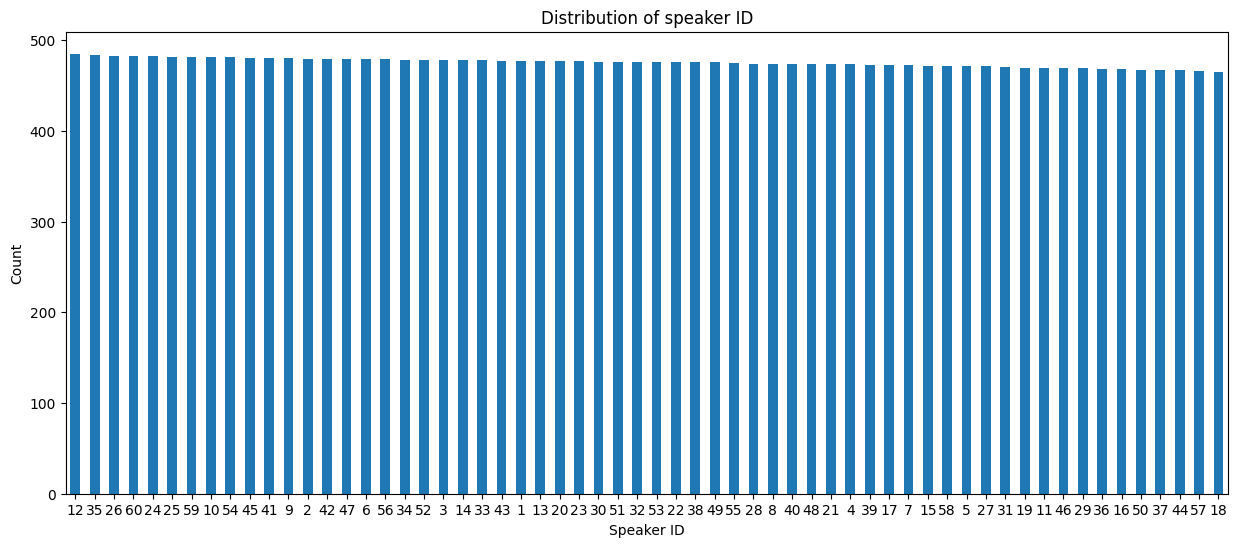

In [14]:
# visualize_data(y_train['label_1'])

series_data_1 = pd.Series(y_train['label_1'])
class_counts_1 = series_data_1.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_1.plot(kind='bar', rot=0)
plt.xlabel('Speaker ID')
plt.ylabel('Count')
plt.title('Distribution of speaker ID')

# Display the bar graph
plt.show()

In [22]:
# Get correlation matrix for scaled dataset
corr_1 = X_train.corr()

In [23]:
X_train_filtered_1_1 = reduce_correlations(corr_1, X_train, 0.9)
print(X_train_filtered_1_1.shape)

(28520, 698)


In [24]:
# Apply PCA
# Perform PCA on filtered dataset
pca_selector_1, X_train_filtered_1_2 = PCA_selection(X_train_filtered_1_1)
print(X_train_filtered_1_2.shape)

(28520, 116)


In [26]:
# Filter the valid dataset as well

X_valid_filtered_1_1 = X_valid[X_train_filtered_1_1.columns]
X_valid_filtered_1_2 = pca_selector_1.transform(X_valid_filtered_1_1)

In [29]:
# Cross validate and choose best model
model_1_cv = cross_validate(X_train_filtered_1_2, y_train_new['label_1'], 8)

Cross validation for KNN done. F-Score :  [0.7635147  0.76135963 0.7629447  0.75501937 0.76224023]
Cross validation for RF done. F-Score :  [0.7496038  0.74392392 0.75255372 0.73758366 0.73599859]
Cross validation for SVM done. F-Score :  [0.83553443 0.83744276 0.8358577  0.82863684 0.82617119]
Max mean f-score :  0.8327285827958761
SVM returned


In [33]:
rs = svm_tuner(model_1_cv, X_train_filtered_1_2, y_train_new['label_1'], X_valid_filtered_1_2, y_valid_new['label_1'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  21.2s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  20.1s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  20.6s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  20.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  20.6s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  20.5s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  20.6s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  22.3s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  22.4s
[CV] END ....................C=10, gamma=0.01, kernel=linear; total time=  22.3s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=  23.0s
[CV] END ...................C=0.1, gamma=0.01, k

In [34]:
# Find the best performing model hyperparameters
rs.best_params_

{'kernel': 'rbf', 'gamma': 0.01, 'C': 1}

In [29]:
from sklearn.model_selection import train_test_split

X_train_new, X_valid_new, y_train_new, y_valid_new = train_test_split(train.iloc[:, :768], train[['label_1', 'label_2', 'label_3', 'label_4']], test_size=0.03, random_state=42)
print(X_train_new.shape, y_train_new.shape)
print(X_valid_new.shape, y_valid_new.shape)

(27664, 768) (27664, 4)
(856, 768) (856, 4)


In [34]:
X_train_1 = X_train_new[X_train_filtered_1_1.columns]
X_train_1_2 = pca_selector_1.transform(X_train_1)

X_valid_1 = X_valid_new[X_train_filtered_1_1.columns]
X_valid_1_2 = pca_selector_1.transform(X_valid_1)

In [39]:
# Train the model accordingly and evaluate
model_1 = SVC(kernel="rbf", C=1000, gamma=1, random_state=42)
model_1.fit(X_train_1_2, y_train_new['label_1'])

SVC(C=1000, gamma=1, random_state=42)

In [40]:
evaluate_model(model_1, X_valid_1_2, y_valid_new['label_1'])

Accuracy:  0.8936915887850467
Confusion matrix: 
[[12  0  0 ...  0  0  0]
 [ 0  8  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 0  0  0 ...  0  0  7]]
Precision, recall, f1-score: 


((0.9008717751590859, 0.8936915887850467, 0.8937227129243971, None),
 array([[12,  0,  0, ...,  0,  0,  0],
        [ 0,  8,  0, ...,  0,  0,  0],
        [ 0,  0,  9, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ..., 10,  0,  0],
        [ 0,  0,  0, ...,  0, 13,  0],
        [ 0,  0,  0, ...,  0,  0,  7]], dtype=int64))

### Hold out method on the training dataset

As the above valid dataset seems to have an issue, let's try to split the training dataset itself into train and valid datasets.

In [59]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(train.iloc[:, :768], train[['label_1', 'label_2', 'label_3', 'label_4']], test_size=0.05, random_state=42)

In [60]:
print('New dataset shapes : ')
print('X_train_ : ', X_train_.shape)
print('y_train_ : ', y_train_.shape)
print('X_valid_ : ', X_valid_.shape)
print('y_valid_ : ', y_valid_.shape)

New dataset shapes : 
X_train_ :  (27094, 768)
y_train_ :  (27094, 4)
X_valid_ :  (1426, 768)
y_valid_ :  (1426, 4)


In [66]:
x_feature_names = ["feature_" + str(i) for i in range(1, 769)]
rob_scaler = RobustScaler()
rob_scaler.fit(X_train_)


X_train_ = pd.DataFrame(rob_scaler.transform(X_train_), columns=x_feature_names)
X_valid_ = pd.DataFrame(rob_scaler.transform(X_valid_), columns=x_feature_names)

In [67]:
# Get correlation matrix and remove highly correlated features

x_corr__1 = X_train_.corr()

In [68]:
X_train_f_1_1 = reduce_correlations(x_corr__1, X_train_, 0.8)
print(X_train_f_1_1.shape)

(27094, 519)


In [69]:
# Apply PCA 
pca_1, X_train_f_1_2 = PCA_selection(X_train_f_1_1)
print(X_train_f_1_2.shape)

(27094, 162)


In [70]:
# Train an SVM model with the same hyperparameters as above selection
model_1_ = SVC(kernel="rbf", C=1, gamma=0.01)
model_1_.fit(X_train_f_1_2, y_train_['label_1'])

SVC(C=1, gamma=0.01)

In [71]:
# Filter the valid dataset as well

X_valid_f_1_1 = X_valid_[X_train_f_1_1.columns]
X_valid_f_1_2 = pca_1.transform(X_valid_f_1_1)
evaluate_model(model_1, X_valid_f_1_2, y_valid_['label_1'])

Accuracy:  0.8197755960729313
Confusion matrix: 
[[18  0  0 ...  0  0  0]
 [ 0 18  0 ...  0  0  0]
 [ 0  0 20 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  0  0]
 [ 0  0  0 ...  0 18  0]
 [ 0  0  0 ...  0  0 15]]
Precision, recall, f1-score: 


((0.8814773470862857, 0.8197755960729313, 0.8418289789601494, None),
 array([[18,  0,  0, ...,  0,  0,  0],
        [ 0, 18,  0, ...,  0,  0,  0],
        [ 0,  0, 20, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ..., 20,  0,  0],
        [ 0,  0,  0, ...,  0, 18,  0],
        [ 0,  0,  0, ...,  0,  0, 15]], dtype=int64))

## Modeling label 2

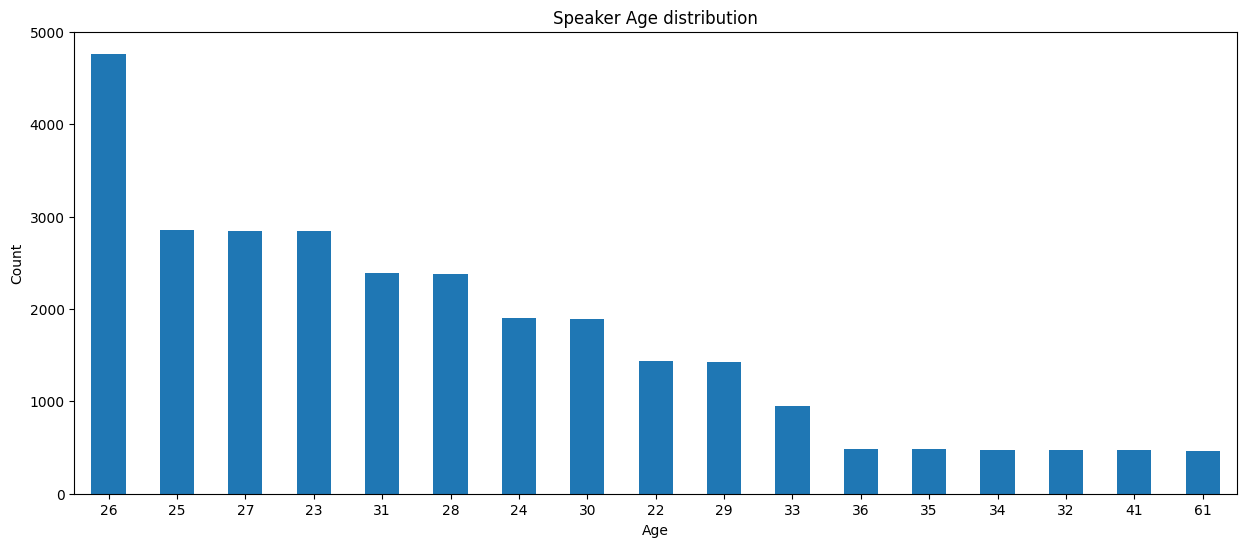

In [46]:
series_data_2 = pd.Series(y_train['label_2'])
class_counts_2 = series_data_2.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_2.plot(kind='bar', rot=0)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Speaker Age distribution')

# Display the bar graph
plt.show()

In [47]:
# Resample data
# Sampling rates calculation

max_count = max(class_counts_2)
print(max_count)
sampling_rates = {}
for c in class_counts_2.keys():
    if class_counts_2[c] > 2000 and class_counts_2[c] < max_count:
        sampling_rates[c] = int(0.95 * max_count)
    elif class_counts_2[c] > 1000 and class_counts_2[c] < max_count:
        sampling_rates[c] = int(0.9 * max_count)
    elif class_counts_2[c] < 1000:
        sampling_rates[c] = int(0.85 * max_count)

print(sampling_rates)

smote_2 = SMOTE(sampling_strategy=sampling_rates, random_state=42)
Xr_train_2, yr_train_2= smote_2.fit_resample(X_train, y_train['label_2'])

4762
{25: 4523, 27: 4523, 23: 4523, 31: 4523, 28: 4523, 24: 4285, 30: 4285, 22: 4285, 29: 4285, 33: 4047, 36: 4047, 35: 4047, 34: 4047, 32: 4047, 41: 4047, 61: 4047}


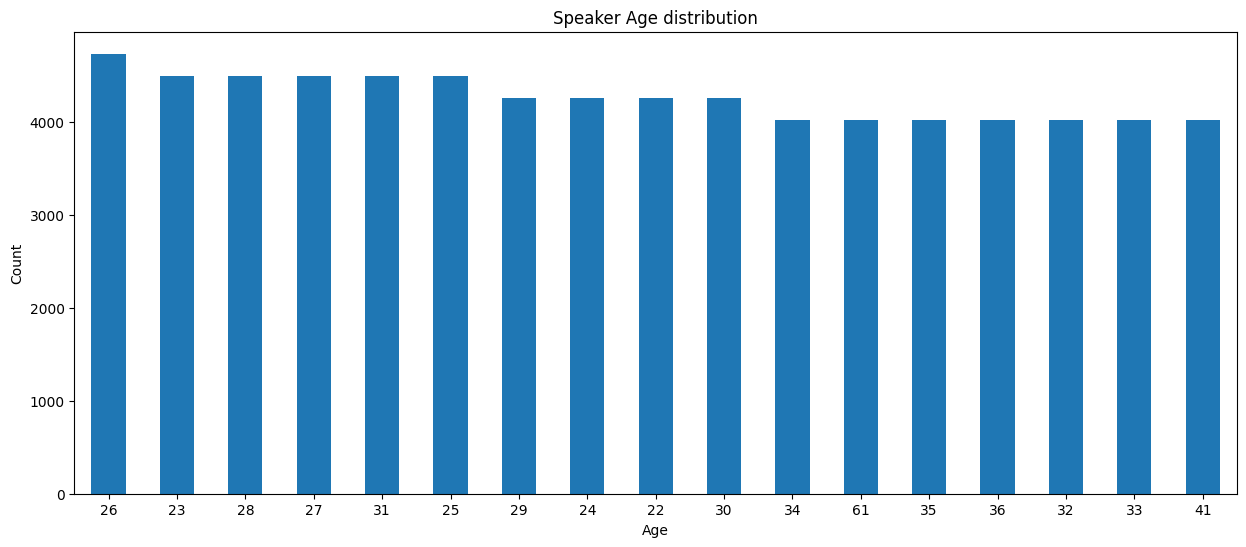

In [82]:
series_data_2_2 = pd.Series(yr_train)
class_counts_2_2 = series_data_2_2.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_2_2.plot(kind='bar', rot=0)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Speaker Age distribution')

# Display the bar graph
plt.show()

In [48]:
# X_train_filtered_2_1 = reduce_correlations(corr_2, Xr_train, 0.8)
X_train_filtered_2_1 = Xr_train[X_train_filtered_1_1.columns]
print(X_train_filtered_2_1.shape)

(72846, 698)


In [89]:
# Perform PCA on filtered dataset
pca_selector_2, X_train_filtered_2_2 = PCA_selection(X_train_filtered_2_1)
print(X_train_filtered_2_2.shape)

(72846, 99)


In [47]:
# Cross validate and choose best model
model_2_cv = cross_validate(X_train_filtered_2_2, yr_train)

Cross validation for KNN done. F-Score :  [0.87457697 0.88258858 0.8973686  0.93500483 0.938113  ]
Cross validation for RF done. F-Score :  [0.91104358 0.91684509 0.93127978 0.97133582 0.97824285]
Cross validation for SVM done. F-Score :  [0.82250155 0.84052766 0.84750328 0.87574251 0.87470645]
Max mean f-score :  0.9417494243894066
RF returned


In [88]:
# X_valid_filtered_2_1 = X_valid[X_train_filtered_2_1.columns]
# X_valid_filtered_2_2 = pca_selector_2.transform(X_valid_filtered_2_1)
# print(X_valid_filtered_2_2.shape)
# print(y_valid_new['label_2'].shape)

(879, 129)
(879,)


In [88]:
X_train_2, yr_train_2 = smote_2.fit_resample(X_train_new, y_train_new['label_2'])
X_train_2 = X_train_2[X_train_filtered_2_1.columns]
X_train_2_2 = pca_selector_2.transform(X_train_2)

X_valid_2 = X_valid_new[X_train_filtered_2_1.columns]
X_valid_2_2 = pca_selector_2.transform(X_valid_2)

In [54]:
# rs = rf_tuner(model_2_cv, X_train_filtered_2_2, yr_train, X_valid_filtered_2_2, y_valid_new['label_2'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=600; total time= 5.9min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=600; total time= 6.0min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=600; total time= 5.7min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=600; total time= 5.4min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=600; total time= 5.9min


C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=800; total time=23.8min


C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=800; total time= 8.3min


C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


KeyboardInterrupt: 

In [55]:
# Train the model accordingly and evaluate
# 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 100
model_2 = RandomForestClassifier(n_estimators=200, max_depth=100)
model_2.fit(X_train_2_2, yr_train_2)

RandomForestClassifier(max_depth=100, n_estimators=200)

In [57]:
model_2_cv = RandomForestClassifier()
model_2_cv.fit(X_train_2_2, yr_train_2)

RandomForestClassifier()

In [59]:
evaluate_model(model_2_cv, X_valid_2_2, y_valid_new['label_2'])

Accuracy:  0.7511682242990654
Confusion matrix: 
[[ 33   2   1   3   5   1   0   2   0   0   0   0   1   0   0   0   0]
 [  4  65   7   3   7   2   2   2   1   3   0   0   0   0   0   0   0]
 [  1   4  27   1  10   2   1   0   0   0   1   0   0   0   0   0   0]
 [  0   2   1  68   9   0   2   0   2   1   0   0   0   0   0   0   0]
 [  0   8   1   7 128   3   2   0   2   3   1   1   0   0   0   0   1]
 [  0   3   1   3   6  53   3   1   2   2   0   0   1   0   0   0   0]
 [  0   2   0   1   7   3  56   0   0   2   0   0   0   0   0   1   0]
 [  1   1   2   2   6   0   1  24   0   1   0   0   0   0   0   0   0]
 [  0   2   1   2   3   0   1   0  45   1   1   2   0   0   0   1   0]
 [  0   6   0   0   3   2   2   0   2  46   0   1   1   0   0   2   1]
 [  0   0   0   0   0   0   0   0   0   0   8   1   0   0   0   0   0]
 [  0   1   0   1   3   0   0   0   0   1   0  24   0   0   0   0   0]
 [  1   0   0   0   0   0   0   1   0   0   0   0   8   0   0   0   0]
 [  0   0   0   0   1   0   

((0.7565262550939261, 0.7511682242990654, 0.7508388324471729, None),
 array([[ 33,   2,   1,   3,   5,   1,   0,   2,   0,   0,   0,   0,   1,
           0,   0,   0,   0],
        [  4,  65,   7,   3,   7,   2,   2,   2,   1,   3,   0,   0,   0,
           0,   0,   0,   0],
        [  1,   4,  27,   1,  10,   2,   1,   0,   0,   0,   1,   0,   0,
           0,   0,   0,   0],
        [  0,   2,   1,  68,   9,   0,   2,   0,   2,   1,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   8,   1,   7, 128,   3,   2,   0,   2,   3,   1,   1,   0,
           0,   0,   0,   1],
        [  0,   3,   1,   3,   6,  53,   3,   1,   2,   2,   0,   0,   1,
           0,   0,   0,   0],
        [  0,   2,   0,   1,   7,   3,  56,   0,   0,   2,   0,   0,   0,
           0,   0,   1,   0],
        [  1,   1,   2,   2,   6,   0,   1,  24,   0,   1,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   2,   1,   2,   3,   0,   1,   0,  45,   1,   1,   2,   0,
           0,   0,   1,  

## Modeling Label 3

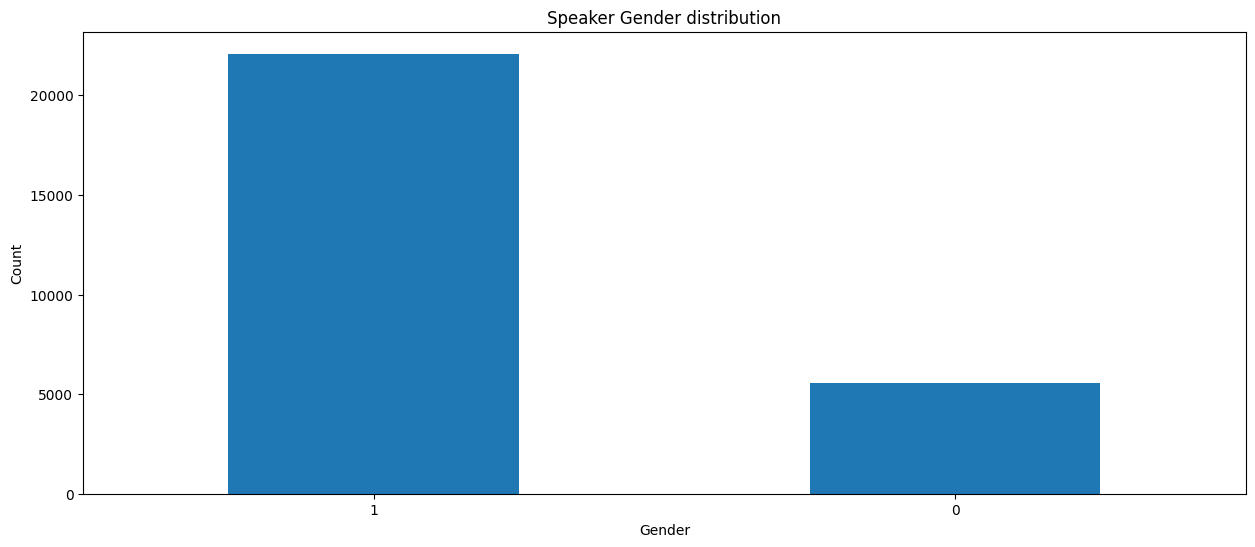

In [60]:
series_data_3 = pd.Series(y_train_new['label_3'])
class_counts_3 = series_data_3.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_3.plot(kind='bar', rot=0)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Speaker Gender distribution')

# Display the bar graph
plt.show()

In [61]:
smote_3 = SMOTE(sampling_strategy= 'auto', random_state=42)
Xr_train_3, yr_train_3 = smote_3.fit_resample(X_train_new, y_train_new['label_3'])

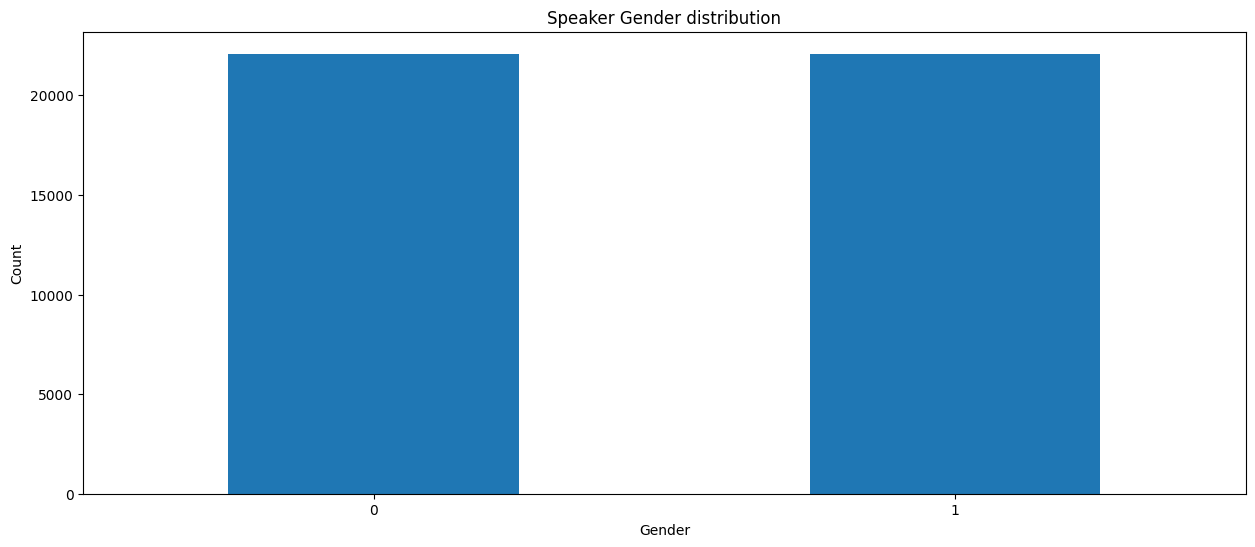

In [62]:
series_data_3_2 = pd.Series(yr_train)
class_counts_3_2 = series_data_3_2.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_3_2.plot(kind='bar', rot=0)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Speaker Gender distribution')

# Display the bar graph
plt.show()

In [100]:
corr_3 = Xr_train.corr()

In [72]:
# X_train_filtered_3_1 = reduce_correlations(corr_2, Xr_train, 0.9)
X_train_filtered_3_1 = Xr_train[X_train_filtered_1_1.columns]
X_train_filtered_3_1.shape

(44184, 698)

In [90]:
# Apply PCA
pca_selector_3, X_train_filtered_3_2 = PCA_selection(X_train_filtered_3_1)
print(X_train_filtered_3_2.shape)

(44184, 106)


In [104]:
# Cross validate and choose best model
model_3_cv = cross_validate(X_train_filtered_3_2, yr_train)

Cross validation for KNN done. F-Score :  [0.95219738 0.955722   0.95351399 0.95417493 0.95439524]
Cross validation for RF done. F-Score :  [0.98568124 0.99052759 0.99328046 0.99416171 0.99504296]
Cross validation for SVM done. F-Score :  [0.98876528 0.99251019 0.99096717 0.99217889 0.99162811]
Max mean f-score :  0.9917387924909986
RF returned


In [74]:
model_3 = RandomForestClassifier()
model_3.fit(X_train_filtered_3_2, yr_train)

RandomForestClassifier()

In [75]:
# Transform valid dataset
X_valid_filtered_3_1 = X_valid_new[X_train_filtered_3_1.columns]
X_valid_filtered_3_2 = pca_selector_3.transform(X_valid_filtered_3_1)
print(X_valid_filtered_3_2.shape)
print(y_valid_new['label_3'].shape)

(856, 106)
(856,)


In [77]:
evaluate_model(model_3, X_valid_filtered_3_2, y_valid_new['label_3'])

Accuracy:  0.9766355140186916
Confusion matrix: 
[[137  15]
 [  5 699]]
Precision, recall, f1-score: 


((0.9764695927074265, 0.9766355140186916, 0.9763205441674712, None),
 array([[137,  15],
        [  5, 699]], dtype=int64))

In [108]:
rs = rf_tuner(model_2_cv, X_train_filtered_3_2, yr_train, X_valid_filtered_3_2, y_valid_new['label_3'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....................max_depth=60, n_estimators=900; total time= 3.1min
[CV] END .....................max_depth=60, n_estimators=900; total time= 3.0min
[CV] END .....................max_depth=60, n_estimators=900; total time= 3.0min
[CV] END .....................max_depth=60, n_estimators=900; total time=10.1min
[CV] END .....................max_depth=60, n_estimators=900; total time= 3.1min
[CV] END .....................max_depth=40, n_estimators=500; total time= 1.8min
[CV] END .....................max_depth=40, n_estimators=500; total time= 1.8min
[CV] END .....................max_depth=40, n_estimators=500; total time= 1.9min
[CV] END .....................max_depth=40, n_estimators=500; total time= 1.9min
[CV] END .....................max_depth=40, n_estimators=500; total time= 1.8min
[CV] END ....................max_depth=100, n_estimators=600; total time= 2.7min


KeyboardInterrupt: 

## Modeling label 4

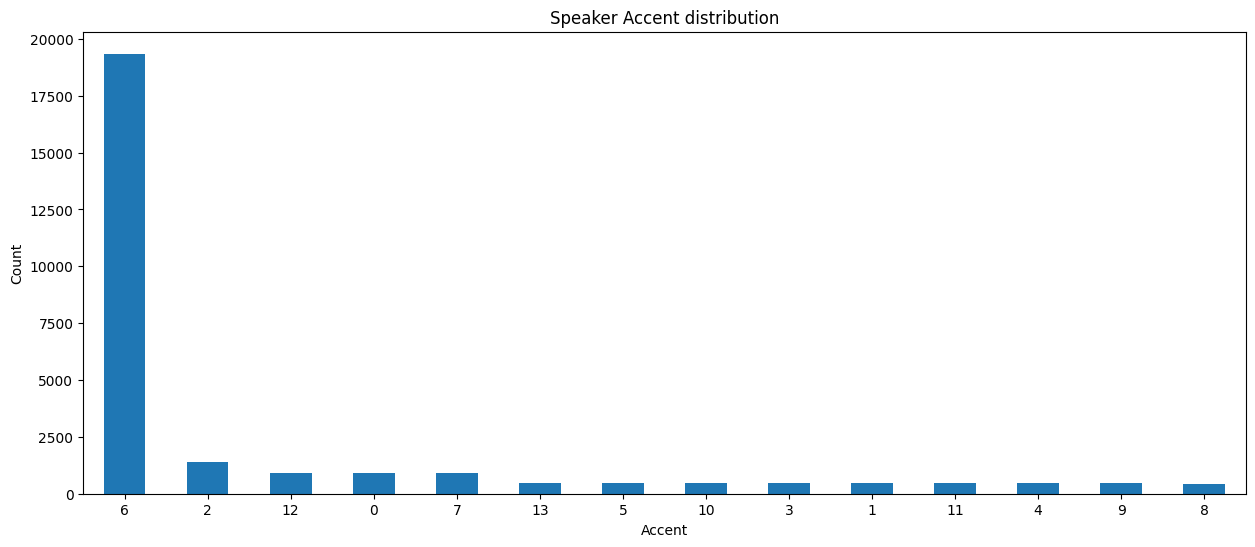

In [78]:
series_data_4 = pd.Series(y_train_new['label_4'])
class_counts_4 = series_data_4.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_4.plot(kind='bar', rot=0)
plt.xlabel('Accent')
plt.ylabel('Count')
plt.title('Speaker Accent distribution')

# Display the bar graph
plt.show()

In [79]:
from imblearn.over_sampling import SMOTE

# Instantiate the SMOTE sampler
smote_4 = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the data
Xr_train_4, yr_train_4 = smote_4.fit_resample(X_train_new, y_train_new['label_4'])

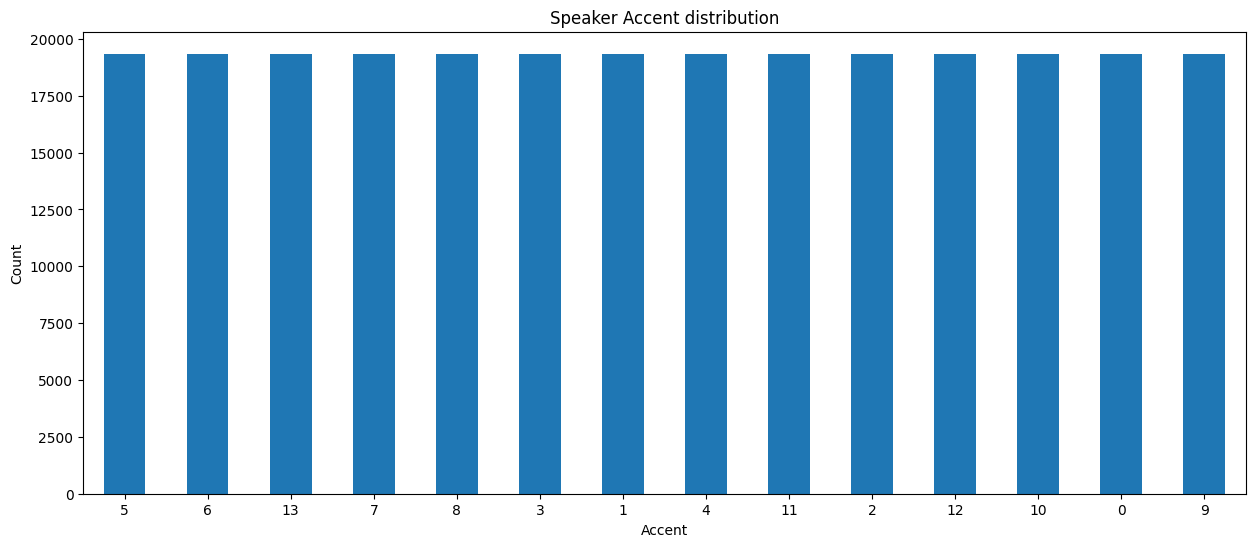

In [80]:
series_data_4_2 = pd.Series(yr_train_4)
class_counts_4_2 = series_data_4_2.value_counts()

plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
class_counts_4_2.plot(kind='bar', rot=0)
plt.xlabel('Accent')
plt.ylabel('Count')
plt.title('Speaker Accent distribution')

# Display the bar graph
plt.show()

In [114]:
corr_4 = Xr_train_4.corr()

In [81]:
# X_train_filtered_4_1 = reduce_correlations(corr_4, Xr_train_4, 0.8)
X_train_filtered_4_1 = Xr_train_4[X_train_filtered_1_1.columns]
print(X_train_filtered_4_1.shape)

(270900, 698)


<Axes: >

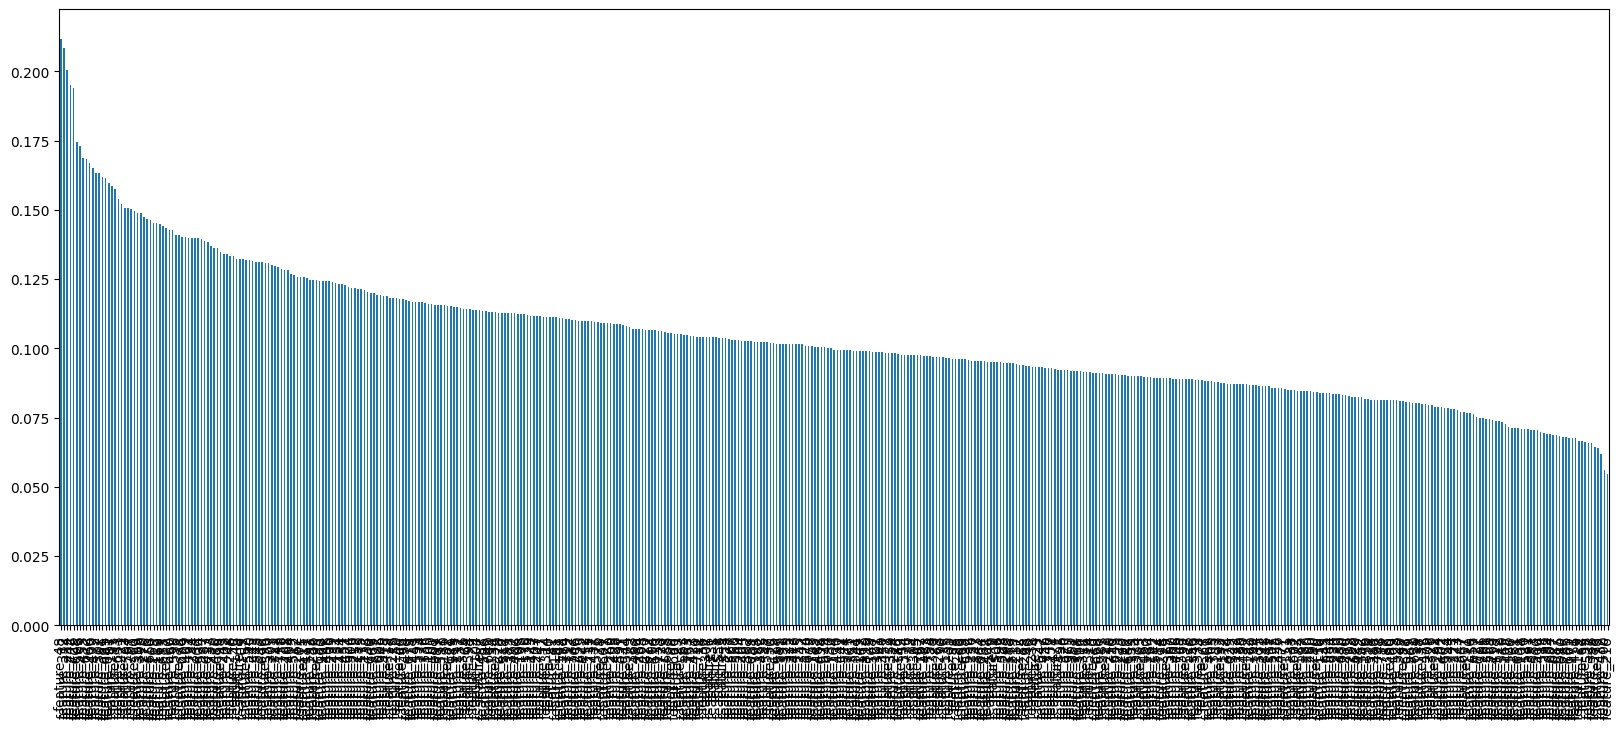

In [120]:
# Visualize mutual information

mutual_info_4 = mutual_info_classif(X_train_filtered_4_1, yr_train_4)
mutual_info_4 = pd.Series(mutual_info_4)
mutual_info_4.index = X_train_filtered_4_1.columns
mutual_info_4.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [123]:
mi_count_4 = mutual_info_4[mutual_info_4 > 0.08].count()
mi_count_4

426

In [124]:
selector4 = SelectKBest(score_func=mutual_info_classif, k=mi_count_4)
X_train_filtered_4_2 = selector4.fit_transform(X_train_filtered_4_1, yr_train_4)
X_train_filtered_4_2.shape

(277816, 426)

In [82]:
# Perform PCA on filtered dataset
pca_selector_4, X_train_filtered_4_3 = PCA_selection(X_train_filtered_4_1)
print(X_train_filtered_4_3.shape)

(270900, 82)


In [126]:
# Cross validate and choose best model
model_4_cv = cross_validate(X_train_filtered_4_2, yr_train_4)

KeyboardInterrupt: 

In [83]:
model_4 = RandomForestClassifier()
model_4.fit(X_train_filtered_4_3, yr_train_4)

RandomForestClassifier()

In [84]:
# Transform valid dataset
X_valid_filtered_4_1 = X_valid_new[X_train_filtered_4_1.columns]
# X_valid_filtered_4_2 = selector4.transform(X_valid_filtered_4_1)
X_valid_filtered_4_3 = pca_selector_4.transform(X_valid_filtered_4_1)
print(X_valid_filtered_4_3.shape)
print(y_valid_new['label_4'].shape)

(856, 82)
(856,)


In [85]:
evaluate_model(model_4, X_valid_filtered_4_3, y_valid_new['label_4'])

Accuracy:  0.8808411214953271
Confusion matrix: 
[[ 21   0   0   0   0   0  15   0   0   0   0   0   0   0]
 [  0  10   0   0   0   0  10   0   0   0   0   0   0   0]
 [  1   0  32   0   0   0  10   0   0   0   0   0   0   0]
 [  0   0   0  14   0   0   4   0   0   0   0   0   0   0]
 [  0   0   0   0   7   0   3   0   0   0   1   0   0   0]
 [  0   0   0   0   0   7   3   0   0   0   0   0   0   0]
 [  1   1   3   0   2   1 575   2   1   0   1   0   1   0]
 [  0   0   0   0   0   0  11  20   0   0   0   0   0   0]
 [  0   0   0   0   0   0   6   0   9   0   0   0   1   0]
 [  0   0   0   0   0   0   7   0   0   9   0   0   0   0]
 [  0   0   0   0   0   0   4   1   0   0  11   0   1   0]
 [  0   0   0   0   0   0   3   0   0   0   0  17   0   0]
 [  0   0   0   0   0   0   6   1   0   0   0   0  16   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0   6]]
Precision, recall, f1-score: 


((0.8837469412075626, 0.8808411214953271, 0.8734924922623856, None),
 array([[ 21,   0,   0,   0,   0,   0,  15,   0,   0,   0,   0,   0,   0,
           0],
        [  0,  10,   0,   0,   0,   0,  10,   0,   0,   0,   0,   0,   0,
           0],
        [  1,   0,  32,   0,   0,   0,  10,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,  14,   0,   0,   4,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   7,   0,   3,   0,   0,   0,   1,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   7,   3,   0,   0,   0,   0,   0,   0,
           0],
        [  1,   1,   3,   0,   2,   1, 575,   2,   1,   0,   1,   0,   1,
           0],
        [  0,   0,   0,   0,   0,   0,  11,  20,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   6,   0,   9,   0,   0,   0,   1,
           0],
        [  0,   0,   0,   0,   0,   0,   7,   0,   0,   9,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   

In [137]:
model_4_knn = KNeighborsClassifier()
model_4_knn.fit(X_train_filtered_4_3, yr_train_4)

KNeighborsClassifier()

In [138]:
evaluate_model(model_4_knn, X_valid_filtered_4_3, y_valid_new['label_4'])

Accuracy:  0.7076222980659841
Confusion matrix: 
[[ 24   0   0   0   1   0   2   0   0   0   0   0   0   2]
 [  0  20   0   0   0   0   2   0   0   0   0   1   0   1]
 [  1   2  32   0   0   0   2   0   0   0   0   0   0   0]
 [  0   1   2  13   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0  11   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   7   1   1   0   0   0   0   0   0]
 [ 36  20  33  12  15  10 418  19  17   7  11   0  19   9]
 [  1   0   1   0   0   0   1  16   0   1   1   0   0   0]
 [  0   0   0   0   1   0   1   0  13   1   0   0   0   0]
 [  0   0   0   0   1   0   2   0   1  15   2   0   0   0]
 [  1   1   0   0   0   0   1   2   0   2   9   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   8   0   0]
 [  1   0   1   1   0   0   1   1   0   0   0   0  25   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0  11]]
Precision, recall, f1-score: 


((0.8235235315026791, 0.7076222980659841, 0.7319029400888187, None),
 array([[ 24,   0,   0,   0,   1,   0,   2,   0,   0,   0,   0,   0,   0,
           2],
        [  0,  20,   0,   0,   0,   0,   2,   0,   0,   0,   0,   1,   0,
           1],
        [  1,   2,  32,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   1,   2,  13,   0,   0,   0,   0,   0,   0,   0,   0,   1,
           0],
        [  0,   0,   0,   0,  11,   0,   1,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   7,   1,   1,   0,   0,   0,   0,   0,
           0],
        [ 36,  20,  33,  12,  15,  10, 418,  19,  17,   7,  11,   0,  19,
           9],
        [  1,   0,   1,   0,   0,   0,   1,  16,   0,   1,   1,   0,   0,
           0],
        [  0,   0,   0,   0,   1,   0,   1,   0,  13,   1,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   1,   0,   2,   0,   1,  15,   2,   0,   0,
           0],
        [  1,   1,   0,   0,   0,   0,   

In [139]:
model_4_svm = SVC()
model_4_svm.fit(X_train_filtered_4_3, yr_train_4)

SVC()

In [140]:
evaluate_model(model_4_svm, X_valid_filtered_4_3, y_valid_new['label_4'])

Accuracy:  0.8304891922639362
Confusion matrix: 
[[ 25   0   0   0   0   0   4   0   0   0   0   0   0   0]
 [  0  22   0   0   0   0   1   0   0   0   0   1   0   0]
 [  0   0  32   1   0   0   4   0   0   0   0   0   0   0]
 [  0   0   0  16   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   9   0   3   0   0   0   0   0   0   0]
 [  0   0   0   1   0   7   1   0   0   0   0   0   0   0]
 [ 12   6  29   5  12   7 515  14   9   1   3   0  12   1]
 [  0   0   0   0   0   0   3  17   0   0   1   0   0   0]
 [  0   0   0   0   0   0   3   0  13   0   0   0   0   0]
 [  0   0   0   0   2   0   1   0   0  17   0   1   0   0]
 [  0   0   0   0   1   0   4   0   0   0  11   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   8   0   0]
 [  0   0   1   0   0   0   2   0   0   0   0   0  27   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0  11]]
Precision, recall, f1-score: 


((0.8683064450023613, 0.8304891922639362, 0.8407043099012959, None),
 array([[ 25,   0,   0,   0,   0,   0,   4,   0,   0,   0,   0,   0,   0,
           0],
        [  0,  22,   0,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,
           0],
        [  0,   0,  32,   1,   0,   0,   4,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,  16,   0,   0,   1,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   9,   0,   3,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   1,   0,   7,   1,   0,   0,   0,   0,   0,   0,
           0],
        [ 12,   6,  29,   5,  12,   7, 515,  14,   9,   1,   3,   0,  12,
           1],
        [  0,   0,   0,   0,   0,   0,   3,  17,   0,   0,   1,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   3,   0,  13,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   2,   0,   1,   0,   0,  17,   0,   1,   0,
           0],
        [  0,   0,   0,   0,   1,   0,   

# Test results

In [86]:
# Read test data
test = pd.read_csv('dataset_layer12/test.csv')
test.shape

(744, 769)

In [95]:
# Predict the results for all 4 labels
# Preprocess the data according to the 4 models

## LABEL 1
test_filtered_1_1 = test[X_train_filtered_1_1.columns]
test_filtered_1_2 = pca_selector_1.transform(test_filtered_1_1)

## LABEL 2 
test_filtered_2_1 = test[X_train_filtered_2_1.columns]
test_filtered_2_2 = pca_selector_2.transform(test_filtered_2_1)

## LABEL 3
test_filtered_3_1 = test[X_train_filtered_3_1.columns]
test_filtered_3_2 = pca_selector_3.transform(test_filtered_3_1)

## LABEL 4
test_filtered_4_1 = test[X_train_filtered_4_1.columns]
test_filtered_4_2 = pca_selector_4.transform(test_filtered_4_1)

In [93]:
test_1_pred = model_1.predict(test_filtered_1_2)
test_1_pred

array([26, 18,  1,  7, 58, 46,  7, 22, 29, 26, 33, 19, 54, 51, 23, 48, 23,
        2, 43, 42, 11, 35, 39,  7, 21, 48, 28, 55,  2, 51, 55, 46,  1, 56,
       30, 22, 46,  6, 40, 18, 19, 47,  6, 46, 59, 25, 31, 38,  5, 32, 25,
       56, 39, 37, 32, 29, 46, 52, 28, 34, 16, 47, 55, 24, 23, 18, 20,  6,
       36, 38, 22, 28, 44, 46, 55, 59, 49, 51, 57, 12, 52, 38, 23,  4, 31,
       49, 14, 19, 12, 16, 36, 43, 34, 32, 54, 46, 27,  5,  7, 42, 19, 26,
       31, 36, 53, 10, 12, 33, 54,  2, 57, 37, 17, 50, 46, 46, 17, 34, 32,
       40, 48, 40,  8, 22, 38, 15, 39,  9, 52, 37, 28, 13, 10, 55, 28, 25,
       38, 57, 16, 27, 37,  2, 51, 27, 32, 46, 16, 53, 11, 46, 42, 37, 47,
       50,  3, 41, 19, 51, 15,  8,  3, 18,  5, 28, 46, 49, 16, 40, 17, 20,
       53, 57, 15, 16, 11, 35, 34, 52, 41, 20,  7, 18, 21, 19, 37, 55, 29,
       28, 23, 35, 46, 52, 30, 27,  1,  7, 28, 14,  3, 36, 17, 60, 18,  3,
       22,  9, 46, 25, 17, 26, 19, 36, 36, 21,  1, 44, 39, 47, 38,  6, 50,
       39, 23, 37, 48, 22

In [96]:
test_2_pred = model_2.predict(test_filtered_2_2)
test_2_pred

array([22, 25, 30, 27, 29, 30, 27, 33, 30, 22, 26, 25, 23, 26, 28, 26, 28,
       25, 31, 29, 33, 24, 29, 26, 26, 23, 28, 23, 25, 26, 23, 30, 30, 24,
       28, 33, 24, 25, 26, 25, 23, 23, 25, 30, 31, 22, 26, 32, 25, 23, 22,
       24, 29, 27, 23, 26, 23, 34, 28, 25, 30, 23, 25, 26, 28, 25, 25, 25,
       22, 32, 33, 22, 61, 30, 23, 22, 26, 23, 27, 26, 34, 32, 28, 31, 23,
       41, 31, 23, 26, 30, 22, 31, 25, 24, 31, 30, 31, 25, 27, 29, 23, 22,
       26, 22, 24, 36, 26, 32, 25, 25, 27, 26, 29, 24, 30, 30, 26, 25, 23,
       26, 26, 26, 28, 33, 32, 28, 26, 35, 34, 23, 28, 27, 36, 23, 28, 22,
       26, 27, 30, 31, 24, 25, 26, 31, 23, 61, 30, 24, 33, 30, 29, 27, 23,
       24, 31, 30, 23, 25, 28, 41, 31, 25, 25, 28, 30, 26, 30, 26, 31, 26,
       23, 27, 23, 30, 33, 31, 25, 34, 30, 23, 27, 25, 26, 23, 27, 23, 25,
       28, 28, 24, 30, 34, 28, 29, 26, 27, 28, 25, 31, 22, 26, 27, 25, 31,
       33, 35, 24, 22, 26, 22, 25, 22, 22, 26, 30, 61, 29, 23, 32, 25, 24,
       29, 28, 25, 26, 33

In [97]:
test_3_pred = model_3.predict(test_filtered_3_2)
test_3_pred

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [98]:
test_4_pred = model_4.predict(test_filtered_4_2)
test_4_pred

array([ 2,  8,  6,  6,  6,  6,  6,  6,  6,  2,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  0,  6,  2,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  8,  6,  3,  6,  6,  6,  6,  6,  6,  6,  0,  1,
        6,  6,  7,  0,  6,  6,  5,  6,  6,  6,  3,  6,  2,  6,  6,  6,  6,
        6, 12,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  5, 12,  6,  6,  6,
        6, 12,  4,  6,  6,  6,  6,  6,  6,  6,  6,  7,  6,  6,  0,  4,  2,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  0,
        6,  6,  6,  6,  6, 12,  9,  6, 11,  5,  6,  6,  6,  6,  6,  6,  1,
        6,  6,  6,  7,  6,  6,  6,  6,  0,  6,  6,  6,  6,  6,  0,  7,  3,
        6,  6, 10,  4,  6,  6,  6,  6,  8,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  5, 10,  6,  6,  8,  6,  6,  7,  6,  6,
        6,  6,  2,  6,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6, 13,  6,  6,
        6, 11,  6,  1,  6,  2,  6,  6,  6,  6,  6,  6,  6,  3, 12,  6,  6,
        6,  6,  7,  6,  6

In [99]:
# Write into csv file
import csv

header = ["ID", "label_1", "label_2", "label_3", "label_4"]

with open('190547P_layer12_out.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(744):
        row = [i+1, test_1_pred[i], test_2_pred[i], test_3_pred[i], test_4_pred[i]]
        writer.writerow(row)